# Step #1 Generate Synthetic Data

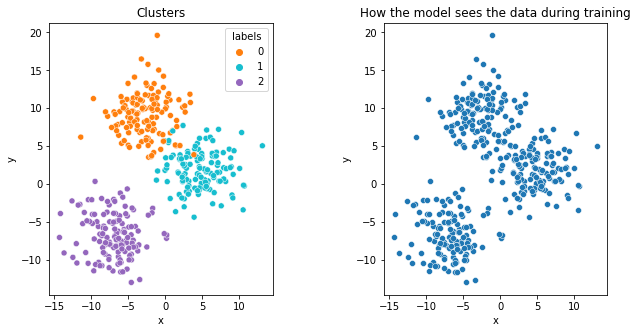

In [63]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split as train_test_split
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# Generate synthetic data
features, labels = make_blobs(
    n_samples=400,
    centers=3,
    cluster_std=2.75,
    random_state=42
)

# Visualize the data in scatterplots
def scatter_plots(df):
    fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(10, 5))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)
    
    palette = {1:"tab:cyan",0:"tab:orange", 2:"tab:purple"}
    ax1 = plt.subplot(1,2,1)
    sns.scatterplot(ax = ax1, data=df, x='x', y='y', hue= 'labels', palette=palette)
    plt.title('Clusters')
    
    ax2 = plt.subplot(1,2,2)
    sns.scatterplot(ax = ax2, data=df, x='x', y='y')
    plt.title('How the model sees the data during training')

    
df = pd.DataFrame(features, columns=['x', 'y'])
df['labels'] = labels
scatter_plots(df)

# Step #2 Scale and Split the Data

In [2]:
# Scale the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

X = scaled_features #Training data
y = labels #Prediction label

# Split the data into x_train and y_train data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=0)

# Step #3 Train a K-Means Clustering Model

In [48]:
# Create a k-means model with n clusters
kmeans = KMeans(
    init="random",
    n_clusters=3,
    n_init=10,
    max_iter=300,
    random_state=42
)

# fit the model
kmeans.fit(X_train)
print(f'Converged after {kmeans.n_iter_} iterations')

Converged after 4 iterations


# Step #4 Visualize the Results

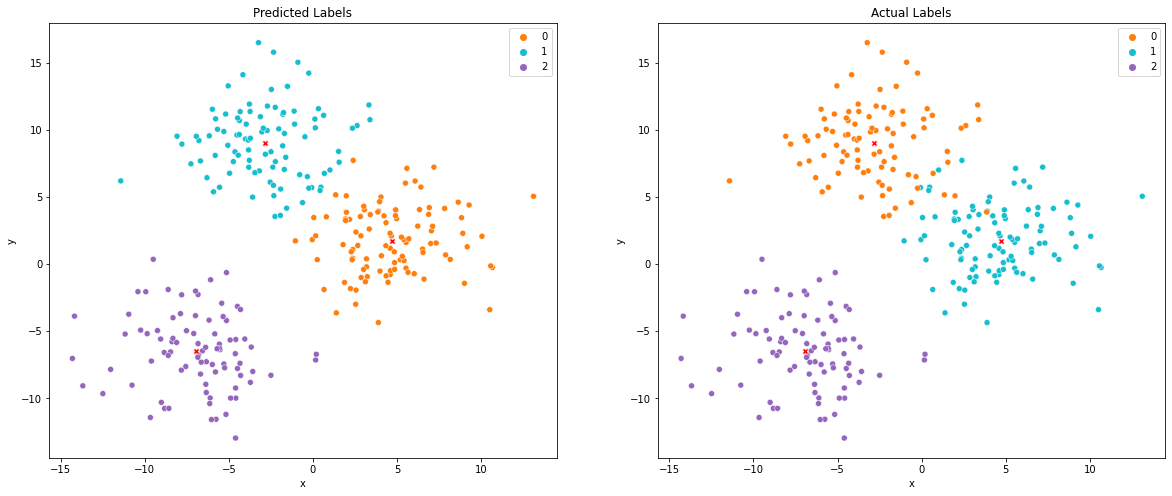

In [82]:
cluster_center = scaler.inverse_transform(kmeans.cluster_centers_)
df_cluster_centers = pd.DataFrame(cluster_center, columns=['x', 'y'])

X_train_unscaled = scaler.inverse_transform(X_train)
df_train = pd.DataFrame(X_train_unscaled, columns=['x', 'y'])
df_train['pred_label'] = kmeans.labels_
df_train['true_label'] = y_train


def scatter_plots(df, cc):
    fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(20, 8))
    fig.subplots_adjust(hspace=0.5, wspace=0.2)
    
    palette = {1:"tab:cyan",0:"tab:orange", 2:"tab:purple"}
    
    # Print the predictions    
    ax2 = plt.subplot(1,2,1)
    sns.scatterplot(ax = ax2, data=df, x='x', y='y', hue='pred_label', palette=palette)
    sns.scatterplot(ax = ax2, data=cc, x='x', y='y', color='r', marker="X")
    plt.title('Predicted Labels')

    
    # print the actual values
    ax1 = plt.subplot(1,2,2)
    sns.scatterplot(ax = ax1, data=df, x='x', y='y', hue= 'true_label', palette=palette)
    sns.scatterplot(ax = ax1, data=cc, x='x', y='y', color='r', marker="X")
    plt.title('Actual Labels')


# The colors between the two plots may not match.
# This is because K-means does not know the initial labels and assigns numbers to clusters 
scatter_plots(df_train, df_cluster_centers)

# Step #5 Measuring Performance

In [54]:
# The predictive model has the labels 0 and 1 reversed. We will correct that first. 
#df_train['pred_test'] = df_train['pred_labels'].map({2:2, 1:3, 0:1})
df_eval = df_train.copy()
df_eval['true_label'] = df_eval['true_label'].map({0:'A', 1:'B', 2:'C'})
df_eval['pred_label'] = df_eval['pred_label'].map({0:'B', 1:'A', 2:'C'})
df_eval.head(10)

,x,y,pred_label,true_label
0,-9.007547,-10.302910,C,C
1,1.009238,7.009681,A,B
2,-6.565501,-6.466780,C,C
3,2.389772,7.727235,B,B
4,-5.422666,-2.915796,C,C
5,-12.024305,-7.846772,C,C
6,-4.006250,9.319323,A,A
7,-6.297788,6.435267,A,A
8,2.169238,3.325947,B,B
9,-5.140506,-4.205585,C,C


<AxesSubplot:xlabel='x', ylabel='y'>

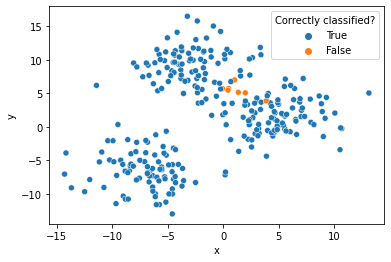

In [92]:
df_eval.loc[df_eval['pred_label'] == df_eval['true_label'], 'Correctly classified?'] = 'True' 
df_eval.loc[df_eval['pred_label'] != df_eval['true_label'], 'Correctly classified?'] = 'False' 

sns.scatterplot(data=df_eval, x='x', y='y', color='r', hue='Correctly classified?')

              precision    recall  f1-score  support
A              0.956989  0.967391  0.962162   92.000
B              0.970297  0.960784  0.965517  102.000
C              1.000000  1.000000  1.000000   86.000
accuracy       0.975000  0.975000  0.975000    0.975
macro avg      0.975762  0.976059  0.975893  280.000
weighted avg   0.975048  0.975000  0.975006  280.000


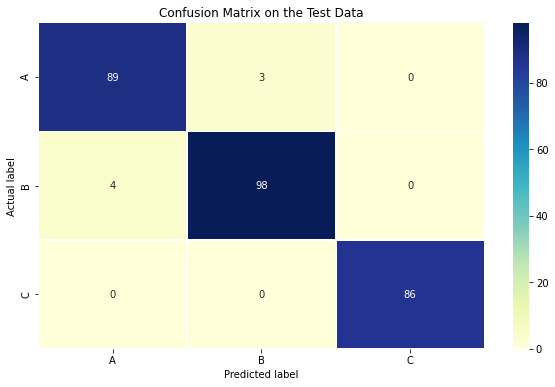

In [78]:
# Evaluate model performance
def evaluate_results(model, y_true, y_pred, class_names):
    tick_marks = [0.5, 1.5, 2.5]
    
    # Print the Confusion Matrix
    fig, ax = plt.subplots(figsize=(10, 6))
    results_log = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    results_df_log = pd.DataFrame(results_log).transpose()
    matrix = confusion_matrix(y_true,  y_pred)
    model_score = score(y_pred, y_true, average='macro')
    
    sns.heatmap(pd.DataFrame(matrix), annot=True, fmt="d", linewidths=.5, cmap="YlGnBu")
    plt.xlabel('Predicted label'); plt.ylabel('Actual label')
    plt.title('Confusion Matrix on the Test Data')
    plt.yticks(tick_marks, class_names); plt.xticks(tick_marks, class_names)
    
    print(results_df_log)


y_true = df_eval['true_label']
y_pred = df_eval['pred_label']
class_names = ['A', 'B', 'C']
evaluate_results(kmeans, y_true, y_pred, class_names)